<a href="https://colab.research.google.com/github/rsidorchuk93/Large_Language_Models/blob/main/eCommerce_reviews_tagging_keywords_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# eCommerce reviews tagging

Leading eCommerce websites tag reviews to help customers understand them better - below some examples

**Shein**

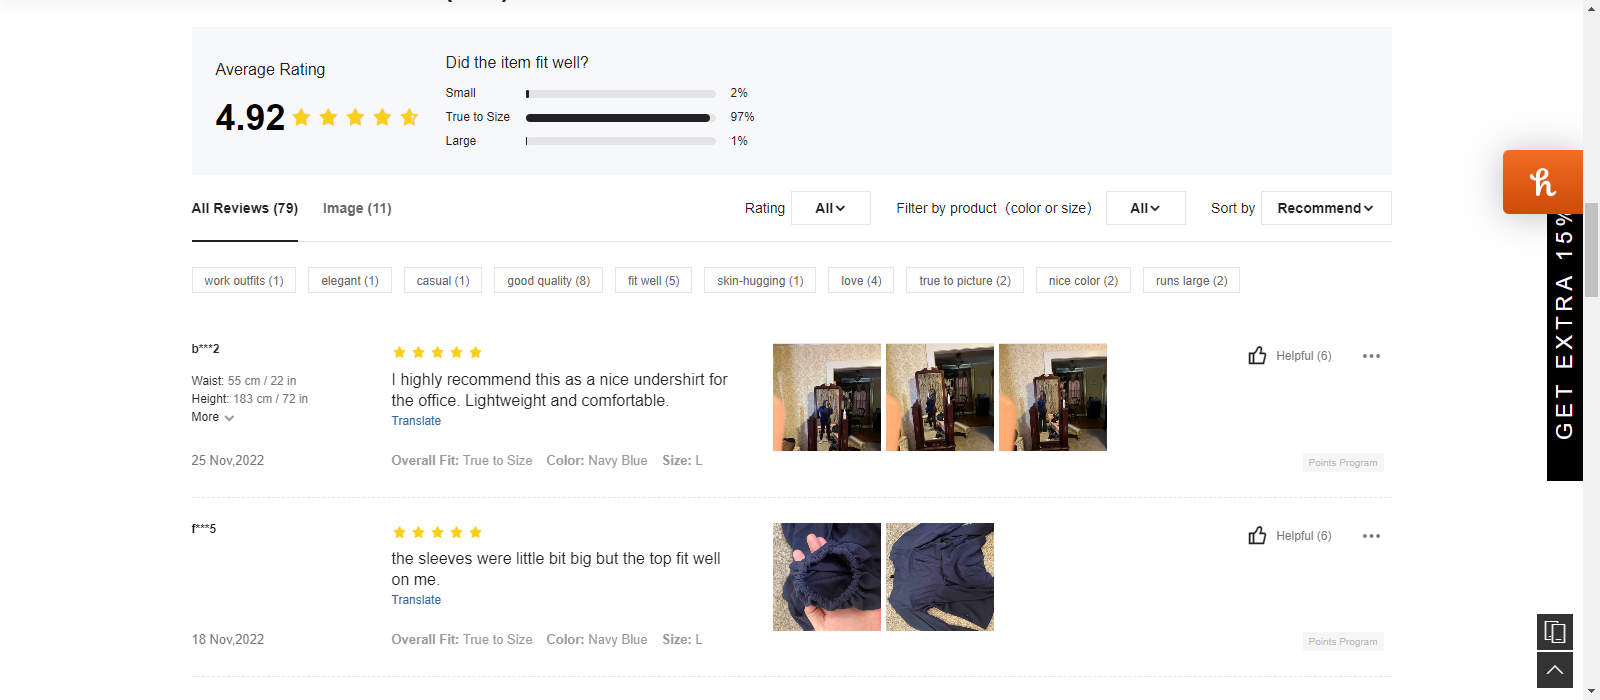

**Amazon**

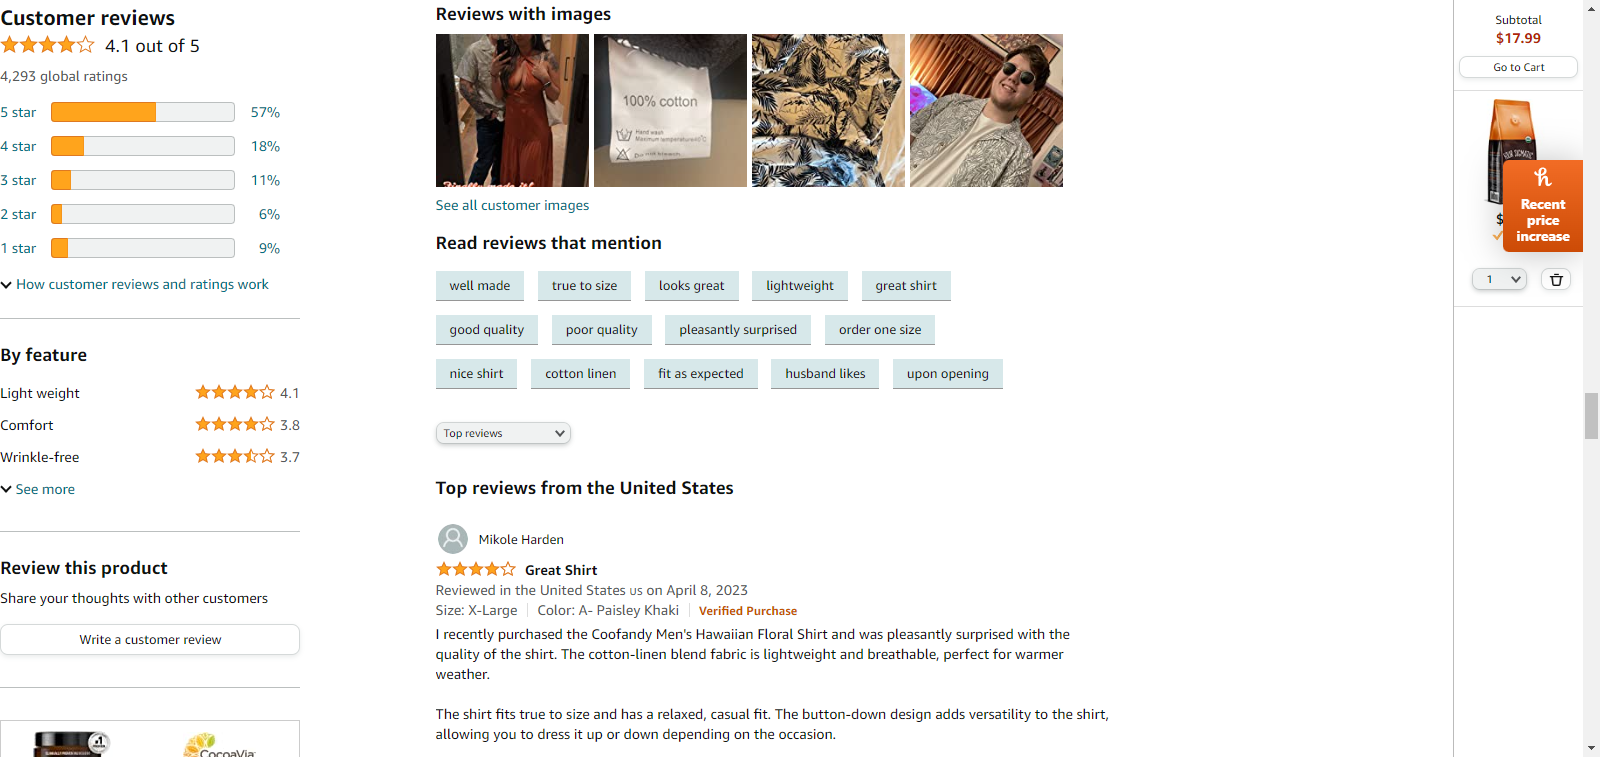

## Setting up environment

In [2]:
# install transformers library
!pip install transformers datasets keybert -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.2 MB/s eta 0:00:00


## Load and preprocess data

In [6]:
# Load the dataset
from datasets import load_dataset

dataset = load_dataset("arize-ai/ecommerce_reviews_with_language_drift")
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating training split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating production split: 0 examples [00:00, ? examples/s]

Dataset ecommerce_reviews_with_language_drift downloaded and prepared to /root/.cache/huggingface/datasets/arize-ai___ecommerce_reviews_with_language_drift/default/1.0.0/48993a0c86ad02873b34f6808021c3150eb8d85a3246eb055fa7c15b0042d7c8. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    training: Dataset({
        features: ['prediction_ts', 'reviewer_age', 'reviewer_gender', 'product_category', 'language', 'text', 'label'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['prediction_ts', 'reviewer_age', 'reviewer_gender', 'product_category', 'language', 'text', 'label'],
        num_rows: 1000
    })
    production: Dataset({
        features: ['prediction_ts', 'reviewer_age', 'reviewer_gender', 'product_category', 'language', 'text', 'label'],
        num_rows: 33411
    })
})

In [7]:
# view sample records from the dataset
for i in range(3):
    print(dataset["training"][i])

{'prediction_ts': 1650092416.0, 'reviewer_age': 21, 'reviewer_gender': 'female', 'product_category': 'apparel', 'language': 'english', 'text': "Poor quality of fabric and ridiculously tight at chest. It's way too short.", 'label': 0}
{'prediction_ts': 1650092544.0, 'reviewer_age': 29, 'reviewer_gender': 'male', 'product_category': 'kitchen', 'language': 'english', 'text': "Love these glasses, thought they'd be everyday glasses, because they were so reasonable, but tgey were so beautiful, tgey are our party/guest glassware now. May need two sets! :) Also bought the smaller size.", 'label': 2}
{'prediction_ts': 1650092672.0, 'reviewer_age': 26, 'reviewer_gender': 'female', 'product_category': 'sports', 'language': 'english', 'text': 'These are disgusting, it tastes like you are "smoking" flower scented air freshener. I am very disappointed :( But then again, I\'m only out $5 so I really can\'t complain. I just wanted to like these so I wouldn\'t have to spend $20+ on mango pods anymore. 

In [8]:
import pandas as pd

# Access the individual datasets
training_dataset = dataset["training"]
validation_dataset = dataset["validation"]
production_dataset = dataset["production"]

# Convert each dataset to a DataFrame
training_df = training_dataset.to_pandas()
validation_df = validation_dataset.to_pandas()
production_df = production_dataset.to_pandas()

# Concatenate the DataFrames
merged_df = pd.concat([training_df, validation_df, production_df], ignore_index=True)

# Display the first few rows of the merged DataFrame
print("First few rows of the merged DataFrame:")
print(merged_df.head())

First few rows of the merged DataFrame:
   prediction_ts  reviewer_age reviewer_gender  product_category language  \
0   1.650092e+09            21          female           apparel  english   
1   1.650093e+09            29            male           kitchen  english   
2   1.650093e+09            26          female            sports  english   
3   1.650093e+09            26            male             other  english   
4   1.650093e+09            37            male  home_improvement  english   

                                                text  label  
0  Poor quality of fabric and ridiculously tight ...      0  
1  Love these glasses, thought they'd be everyday...      2  
2  These are disgusting, it tastes like you are "...      0  
3  My husband has a pair of TaoTronics so I decid...      1  
4  Threads too deep. Engages on tank, but gasket ...      0  


In [9]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42411 entries, 0 to 42410
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   prediction_ts     42411 non-null  float32
 1   reviewer_age      42411 non-null  int16  
 2   reviewer_gender   42411 non-null  object 
 3   product_category  42411 non-null  object 
 4   language          42411 non-null  object 
 5   text              42411 non-null  object 
 6   label             42411 non-null  int64  
dtypes: float32(1), int16(1), int64(1), object(4)
memory usage: 1.9+ MB


In [10]:
# group reviews by product category and sort 
merged_df.groupby('product_category').size().sort_values(ascending = False)[:10]

product_category
home          3852
wireless      3432
apparel       2999
other         2685
beauty        2561
drugstore     2434
kitchen       2204
toy           1916
sports        1745
automotive    1668
dtype: int64

In [11]:
# select only apparel reviews
pd.set_option("display.max_colwidth", None)

apparel_reviews = merged_df[merged_df['product_category'] == 'apparel']
apparel_reviews.head()

,prediction_ts,reviewer_age,reviewer_gender,product_category,language,text,label
0,1.650092e+09,21,female,apparel,english,Poor quality of fabric and ridiculously tight at chest. It's way too short.,0
11,1.650094e+09,23,male,apparel,english,They r really nice glad I bought nice to wear with leggings.,2
38,1.650098e+09,24,male,apparel,english,"This dress was not sewn straight. Two issues: 1) The center seam with buttons is not centered. It's off by about an inch to one side and it's obvious. 2) Where the dress attaches to spaghetti straps is higher on one side than the other. This, too, is obvious. Unfortunately, I will be returning this.",1
43,1.650099e+09,46,male,apparel,english,"Don’t know ! Have not received this product , waaaay overdue .",0
59,1.650101e+09,47,male,apparel,english,It is not true to size.,0


## Calculate unigrams and bigrams as initial step

In [12]:
import nltk
from collections import Counter
import string

nltk.download("stopwords")
nltk.download("wordnet")
stop_words = set(nltk.corpus.stopwords.words("english"))
wnl = nltk.WordNetLemmatizer()

def extract_ngrams(reviews, n=10):
    # Concatenate all reviews into a single string
    all_reviews = " ".join(reviews)
    
    # Pre-processing
    all_reviews = all_reviews.lower()
    all_reviews = all_reviews.translate(str.maketrans("", "", string.punctuation))
    
    # Tokenization
    words = all_reviews.split()
    words = [wnl.lemmatize(word) for word in words if word not in stop_words]
    bigrams = [(words[i], words[i + 1]) for i in range(len(words) - 1)]
    
    # Counting frequency
    unigram_counts = Counter(words)
    bigram_counts = Counter(bigrams)
    
    # Sorting
    sorted_unigram_counts = sorted(unigram_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_bigram_counts = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Extracting the top N unigrams, bigrams, and their frequency
    return [("unigrams", sorted_unigram_counts[:n]),
            ("bigrams", sorted_bigram_counts[:n])
            ]
            
data = apparel_reviews['text'].tolist()
extract_ngrams(data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[('unigrams',
  [('fit', 779),
   ('like', 602),
   ('size', 567),
   ('small', 419),
   ('one', 364),
   ('look', 362),
   ('wear', 357),
   ('ordered', 346),
   ('would', 335),
   ('great', 326)]),
 ('bigrams',
  [(('look', 'like'), 79),
   (('fit', 'well'), 59),
   (('good', 'quality'), 52),
   (('fit', 'perfectly'), 50),
   (('fit', 'great'), 50),
   (('like', 'picture'), 48),
   (('well', 'made'), 45),
   (('really', 'like'), 41),
   (('run', 'small'), 39),
   (('way', 'small'), 36)])]

As a next step, we can use this list to define top tags and assign these tags to reviews

# Now let's use pre-trained Large Language Model BERT for keywords extraction - this model also understands the context

In [13]:
from keybert import KeyBERT
kw_model = KeyBERT()

In [14]:
apparel_reviews_list = apparel_reviews['text'].to_list()

**Example of keywords extraction**

In [15]:
for review in apparel_reviews_list[:5]:
    print("Review: {}".format(review))
    keywords = kw_model.extract_keywords(review, keyphrase_ngram_range=(1, 3), stop_words='english',
                                          use_mmr=True, diversity=0.7)
    print("Keywords:")
    for keyword, score in keywords:
        if score >= 0.4:
            print("- {} ({:.2f})".format(keyword, score))
    print()

Review: Poor quality of fabric and ridiculously tight at chest. It's way too short.
Keywords:
- chest way short (0.67)
- poor quality fabric (0.62)
- ridiculously tight (0.43)

Review: They r really nice glad I bought nice to wear with leggings.
Keywords:
- nice wear leggings (0.83)

Review: This dress was not sewn straight. Two issues: 1) The center seam with buttons is not centered. It's off by about an inch to one side and it's obvious. 2) Where the dress attaches to spaghetti straps is higher on one side than the other. This, too, is obvious. Unfortunately, I will be returning this.
Keywords:
- dress sewn straight (0.78)

Review: Don’t know ! Have not received this product , waaaay overdue .
Keywords:
- product waaaay overdue (0.43)

Review: It is not true to size.
Keywords:
- true size (0.71)



**Building top keywords in our dataset based on their importance in each review**

In [28]:
from collections import Counter

all_keywords = []
for review in apparel_reviews_list:
    keywords = kw_model.extract_keywords(review, keyphrase_ngram_range=(1, 3),
                                          stop_words='english', use_mmr=True,
                                          diversity=0.5)
    keywords = [keyword for keyword, score in keywords if score >= 0.3]
    all_keywords.extend(keywords)

top_keywords = Counter(all_keywords).most_common(20)

print("Top 20 most common keywords:")
for keyword, frequency in top_keywords:
    print("- {} ({} occurrences)".format(keyword, frequency))

Top 20 most common keywords:
- comfortable (43 occurrences)
- small (41 occurrences)
- quality (40 occurrences)
- fit (36 occurrences)
- cute (34 occurrences)
- dress (33 occurrences)
- material (32 occurrences)
- size (25 occurrences)
- shirt (23 occurrences)
- product (19 occurrences)
- soft (19 occurrences)
- received (16 occurrences)
- socks (16 occurrences)
- cheap (15 occurrences)
- short (14 occurrences)
- fits (14 occurrences)
- color (14 occurrences)
- good quality (14 occurrences)
- runs small (13 occurrences)
- warm (13 occurrences)


In [33]:
len(all_keywords)

11326